## prophet

23:21:39 - cmdstanpy - INFO - Chain [1] start processing
23:21:39 - cmdstanpy - INFO - Chain [1] done processing


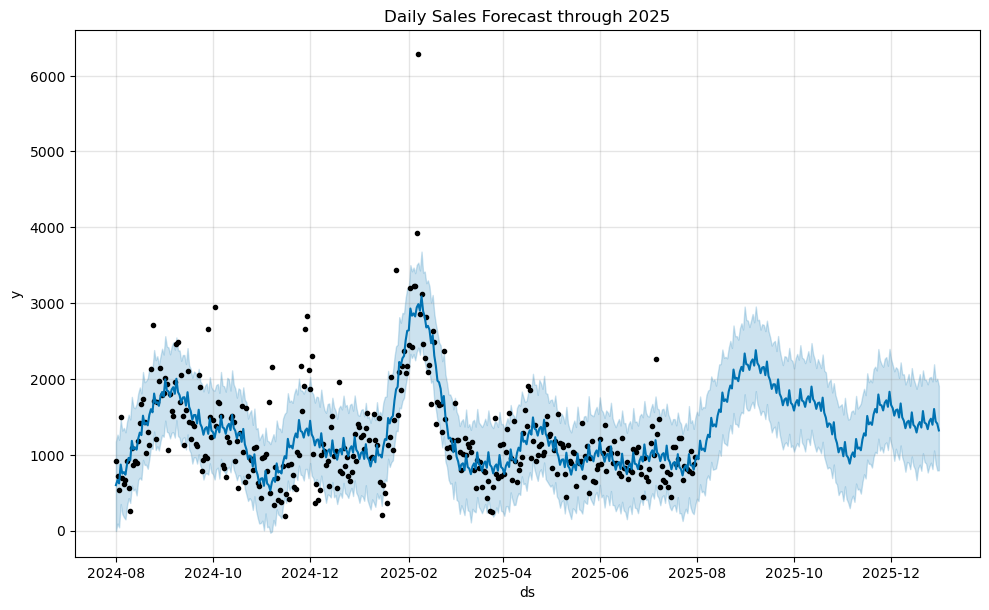

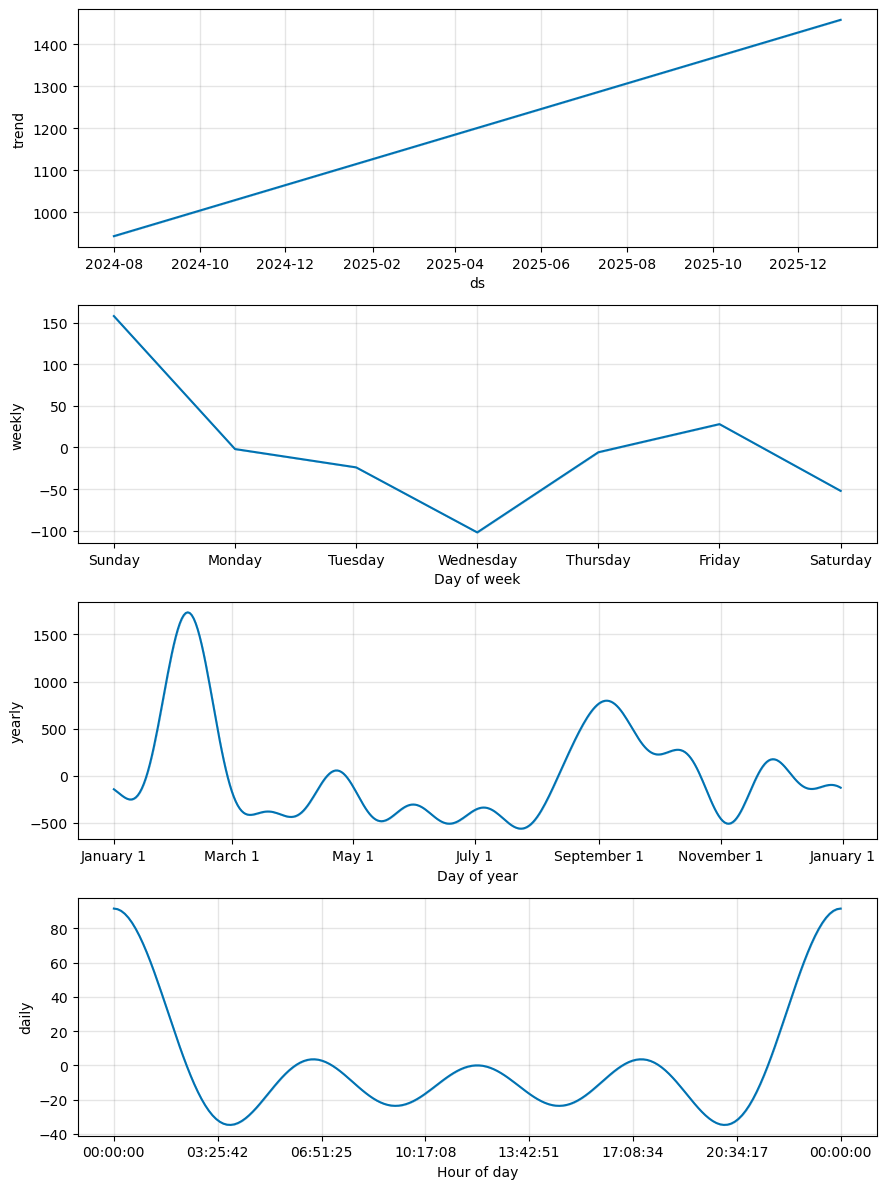

            ds         yhat  yhat_lower   yhat_upper
365 2025-08-01   988.823045  419.663173  1568.708290
366 2025-08-02   940.865914  388.749831  1520.682293
367 2025-08-03  1186.252683  611.518376  1768.448121
368 2025-08-04  1064.061950  506.234275  1600.310586
369 2025-08-05  1082.005515  523.117988  1630.370857
            ds         yhat   yhat_lower   yhat_upper
513 2025-12-27  1395.578190   810.763006  1967.271626
514 2025-12-28  1603.678465  1056.520879  2193.431546
515 2025-12-29  1438.913495   879.815043  1970.752681
516 2025-12-30  1409.297683   793.379441  2003.132207
517 2025-12-31  1320.920679   794.525479  1908.479503


In [30]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

df = pd.read_csv("cleaned_data.csv")

# replace with your actual column names
date_col = "order_day"      # datetime column
target_col = "gross_sales"  # numeric sales column

# aggregate to daily
daily = (
    df.dropna(subset=[date_col])
      .groupby(pd.to_datetime(df[date_col]).dt.date)[target_col]
      .sum()
      .reset_index()
)
daily[date_col] = pd.to_datetime(daily[date_col])
df_prophet = daily.rename(columns={date_col: "ds", target_col: "y"})

# build & fit model
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit(df_prophet)

# ceate future dataframe through end of 2025
last_date = df_prophet["ds"].max()
end_date = pd.to_datetime("2025-12-31")
n_days = (end_date - last_date).days

future = m.make_future_dataframe(periods=n_days, freq="D")

# forecast
forecast = m.predict(future)

# plot
m.plot(forecast)
plt.title("Daily Sales Forecast through 2025")
plt.show()
m.plot_components(forecast) #plots the components
plt.show()

# inspect only future predictions for 2025 
future_preds = forecast[forecast["ds"] > last_date][["ds", "yhat", "yhat_lower", "yhat_upper"]]
print(future_preds.head())
print(future_preds.tail())

In [31]:
future_preds.to_csv("sales_forecast_2025.csv", index=False)

In [11]:
from sklearn.metrics import mean_absolute_percentage_error

# merge actuals with forecast
merged = forecast[["ds", "yhat"]].merge(df_prophet, on="ds", how="inner")

# calculate MAPE (scikit-learn version)
mape = mean_absolute_percentage_error(merged["y"], merged["yhat"]) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 31.95%


## holidays 

23:23:57 - cmdstanpy - INFO - Chain [1] start processing
23:23:57 - cmdstanpy - INFO - Chain [1] done processing


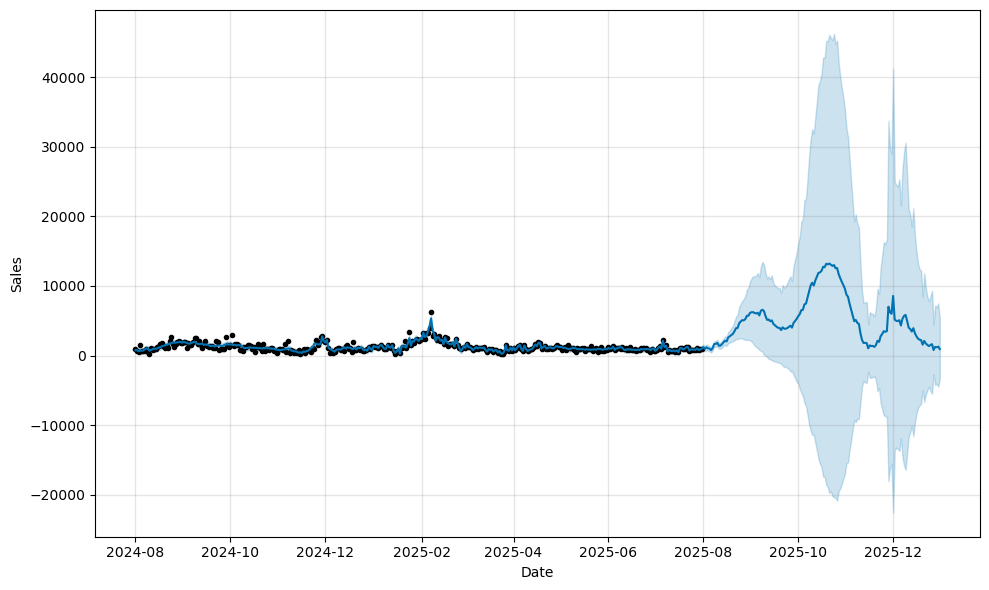

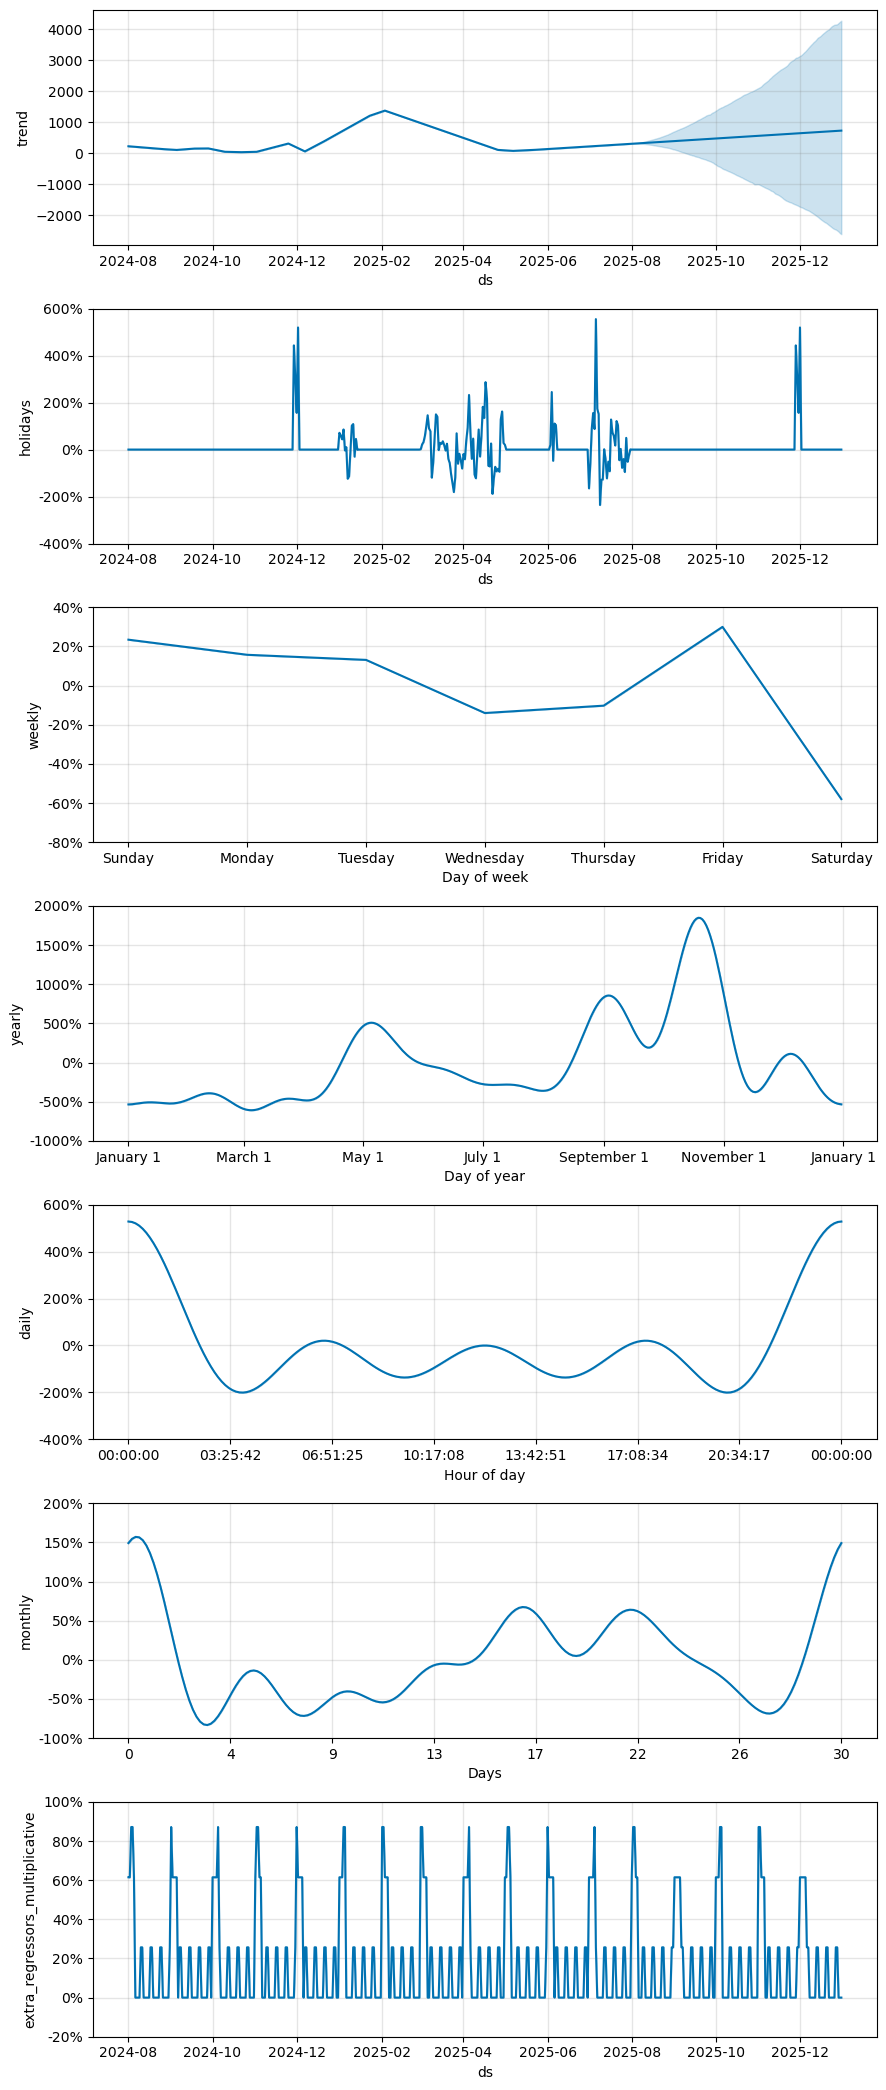

MAPE: 18.13%

Future predictions (head):
             ds         yhat  yhat_lower   yhat_upper
365 2025-08-01  1212.600708  867.022809  1578.430912
366 2025-08-02   952.885073  583.825109  1317.479431
367 2025-08-03  1182.571613  812.218486  1590.131186
368 2025-08-04  1032.052649  658.146849  1448.188812
369 2025-08-05   983.352670  600.844289  1340.265970

Future predictions (tail):
             ds         yhat   yhat_lower   yhat_upper
513 2025-12-27   786.916652 -2732.910798  4475.322397
514 2025-12-28  1236.683327 -4241.802173  7187.121874
515 2025-12-29  1183.878901 -4029.036103  6942.315943
516 2025-12-30  1281.550360 -4466.589236  7492.941982
517 2025-12-31   919.422210 -3374.467921  5356.350907


In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import date, timedelta
from sklearn.metrics import mean_absolute_percentage_error


CSV_PATH = "cleaned_data.csv"
DATE_COL = "order_day"       # datetime column
TARGET_COL = "gross_sales"   # numeric column
FORECAST_END = pd.Timestamp("2025-12-31")

# LOAD & DAILY AGG
df = pd.read_csv(CSV_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL])

daily = (
    df.assign(ds=df[DATE_COL].dt.normalize())
      .groupby("ds")[TARGET_COL].sum().reset_index()
      .rename(columns={TARGET_COL: "y"})
)
# ensure continuous index with explicit zero-sales days
full_days = pd.date_range(daily["ds"].min(), daily["ds"].max(), freq="D")
daily = (
    daily.set_index("ds")
         .reindex(full_days)
         .rename_axis("ds")
         .reset_index()
         .fillna({"y": 0.0})
)

# =========================
# SUSTAINABILITY/BEHAVIORAL EVENTS
# =========================
def make_sustainability_events(min_year: int, max_year: int) -> pd.DataFrame:
    """
    Build holiday-like events relevant to an eco household cleaner.

    Windows:
    - New Year green habits (Jan 1–14)          -> 'new_year_green'
    - Spring cleaning (Mar 1–Apr 15)            -> 'spring_cleaning'
    - World Water Day (Mar 22, ±1d)             -> 'world_water_day'
    - Earth Month (Apr 1–30) centered on Apr 22 -> 'earth_month'
    - World Environment Day (Jun 5, ±2d)        -> 'world_env_day'
    - Plastic Free July (Jul 1–31)              -> 'plastic_free_july'
    - Black Friday (Fri..Mon) / Cyber Monday    -> lower prior (kept for ecommerce)
    """
    rows = []

    def us_thanksgiving(y):
        d = date(y, 11, 1)
        first_thu = d + timedelta(days=(3 - d.weekday()) % 7)  # Thu=3
        return first_thu + timedelta(weeks=3)
    def black_friday(y): return us_thanksgiving(y) + timedelta(days=1)
    def cyber_monday(y):
        tg = us_thanksgiving(y)
        return tg + timedelta(days=(7 - tg.weekday()) % 7)

    for y in range(min_year, max_year + 1):
        # New Year green habits (use Jan 1 as anchor; set window later)
        rows.append({"holiday": "new_year_green", "ds": pd.Timestamp(date(y, 1, 1)), "lower_window": 0, "upper_window": 13})

        # Spring cleaning (anchor Mar 15; wide window covers Mar 1–Apr 15)
        rows.append({"holiday": "spring_cleaning", "ds": pd.Timestamp(date(y, 3, 15)), "lower_window": -14, "upper_window": 31})

        # World Water Day (Mar 22, small window)
        rows.append({"holiday": "world_water_day", "ds": pd.Timestamp(date(y, 3, 22)), "lower_window": -1, "upper_window": 1})

        # Earth Month centered on Earth Day (Apr 22) with wide window (whole April)
        rows.append({"holiday": "earth_month", "ds": pd.Timestamp(date(y, 4, 22)), "lower_window": -21, "upper_window": 9})

        # World Environment Day (Jun 5, modest window)
        rows.append({"holiday": "world_env_day", "ds": pd.Timestamp(date(y, 6, 5)), "lower_window": -2, "upper_window": 2})

        # Plastic Free July (anchor Jul 15 with ±15 days to cover July)
        rows.append({"holiday": "plastic_free_july", "ds": pd.Timestamp(date(y, 7, 15)), "lower_window": -14, "upper_window": 16})

        # Retail (lower priority): BF/CM
        rows.append({"holiday": "black_friday", "ds": pd.Timestamp(black_friday(y)), "lower_window": 0, "upper_window": 3})
        rows.append({"holiday": "cyber_monday", "ds": pd.Timestamp(cyber_monday(y)), "lower_window": 0, "upper_window": 0})

    return pd.DataFrame(rows)

min_y = daily["ds"].min().year
max_y = max(FORECAST_END.year, daily["ds"].max().year)
events = make_sustainability_events(min_y, max_y)


# CALENDAR/BEHAVIOR REGRESSORS
def add_behavioural_regs(df_ds: pd.DataFrame) -> pd.DataFrame:
    out = df_ds.copy()
    d = out["ds"].dt

    # Weekend cleaning (Sat=5, Sun=6)
    out["weekend_cleaning"] = d.weekday.isin([5, 6]).astype(int)

    # First-week-of-month restock (days 1–5)
    out["first_week_restock"] = (d.day <= 5).astype(int)

    # Optional: end-of-month (last 2 days) — commented out; uncomment if you see a pattern
    # dim = d.days_in_month
    # out["eom_window"] = ((dim - d.day) < 2).astype(int)

    return out

df_prophet = add_behavioural_regs(daily)

# MODEL
m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.5,

    # sustainability + retail events
    holidays=events,

    # Stronger prior for sustainability/behavior windows; Prophet applies one prior across holidays,
    # so we keep this relatively high, and let retail be present but not dominant
    holidays_prior_scale=12.0,
)

# Smooth monthly seasonality (helps capture replenishment cadence)
m.add_seasonality(name="monthly", period=30.5, fourier_order=8, mode="multiplicative")

# Regressors must be declared BEFORE fit
m.add_regressor("weekend_cleaning",   mode="multiplicative", prior_scale=5.0)
m.add_regressor("first_week_restock", mode="multiplicative", prior_scale=5.0)

# Fit
m.fit(df_prophet[["ds", "y", "weekend_cleaning", "first_week_restock"]])
# If you added eom_window, include it in the column list above.

# FUTURE & FORECAST
last_date = df_prophet["ds"].max()
n_days = max(0, (FORECAST_END - last_date).days)
future = m.make_future_dataframe(periods=n_days, freq="D")

# add the SAME regressors to future
future = add_behavioural_regs(future)

forecast = m.predict(future)

# PLOTS
m.plot(forecast)
plt.xlabel("Date"); plt.ylabel("Sales")
plt.show()

m.plot_components(forecast)
plt.show()

# FUTURE SLICE
future_only = forecast[forecast["ds"] > last_date][["ds","yhat","yhat_lower","yhat_upper"]]
print("\nFuture predictions (head):\n", future_only.head())
print("\nFuture predictions (tail):\n", future_only.tail())

In [29]:
# Merge forecast with actuals to keep everything together
preds = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()
preds = preds.merge(daily[["ds","y"]], on="ds", how="left")  # add actuals if available

# Save to CSV
preds.to_csv("UPDATED_daily_sales_forecast.csv", index=False)

In [33]:
# METRICS (MAPE on history)
merged = forecast.merge(daily[["ds","y"]], on="ds", how="left").dropna(subset=["y"])
mask_pos = merged["y"] > 0
if mask_pos.sum() > 0:
    mape = mean_absolute_percentage_error(merged.loc[mask_pos,"y"], merged.loc[mask_pos,"yhat"]) * 100
    print(f"MAPE: {mape:.2f}%")


MAPE: 18.13%
